In [13]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import multivariate_normal as mvn

import vsem
from vsem_inv_prob import InvProb

import sys
sys.path.append("./../linear_Gaussian/")
from Gaussian import Gaussian

rng = np.random.default_rng(6435)


# Forward Model

In [ ]:
class VSEMLikelihood:

    def __init__(self, rng, n_days, par_names):
        self.rng = rng
        self.n_days = n_days
        self.time_steps, self.driver = vsem.get_PAR_driver(self.n_days, self.rng)
        self.par_names = par_names
        self.d = len(par_names)

        # VSEM forward model.
        self.forward_model = vsem.get_vsem_fwd_model(self.driver, self.par_names, simplify=False)

        # Observation operator defined as monthly averages of LAI.
        self.lai_idx = vsem.get_vsem_output_names().index("LAI")
        self.month_start_idx = np.arange(start=0, stop=self.n_days, step=31)
        month_stop_idx = np.empty_like(self.month_start_idx)
        month_stop_idx[:-1] = self.month_start_idx[1:]
        month_stop_idx[-1] = self.n_days - 1
        self.month_stop_idx = month_stop_idx
        self.month_midpoints = np.round(0.5 * (self.month_start_idx + self.month_stop_idx))

        # Ground truth
        self.par_true = np.array([
            7.92301322e-01, 1.86523322e+00, 6.84170991e-04, 5.04967614e-01,
            2.95868049e+03, 2.58846896e+04, 1.77011520e+03, 6.88359631e-01,
            3.04573410e+00, 2.11415896e+01, 5.58376223e+00
        ])

        self.par_true = vsem.DefaultVSEMPrior(rng=self.rng).sample()
        self.vsem_output_true = self.forward_model(self.par_true)
        self.observable_true = self.obs_op(self.vsem_output_true).flatten()
        self.n = self.observable_true.size
        self._sigma = 0.3 * np.std(self.observable_true)
        self.noise = Gaussian(cov=self._sigma * np.identity(self.n))
        self.y = self.observable_true + self.noise.sample()
        self._likelihood_rv = Gaussian(mean=self.y, cov=self.noise.cov)
        

    def plot_driver(self):
        plt.plot(self.time_steps, self.driver, "o")
        plt.xlabel("days")
        plt.ylabel("PAR")
        plt.show()

    def par_to_obs_map(self, par):
        vsem_output = self.forward_model(par)
        return self.obs_op(vsem_output)

    def obs_op(self, vsem_output):
        """ Observation operator: monthly averages of LAI """
        lai_output = vsem_output[:,:,self.lai_idx]
        monthly_lai_averages = np.array(
            [lai_output[:, start:end].mean(axis=1) for start, end in zip(self.month_start_idx, self.month_stop_idx)]
        )        

        return monthly_lai_averages.T
    
    def log_density(self, par):
        pred_obs = self.par_to_obs_map(par)
        return self._likelihood_rv.log_p(pred_obs)

    def plot_vsem_outputs(self, par, burn_in_start=0, include_predicted_obs=False):
        output = self.forward_model(par)
        fig, axs = vsem.plot_vsem_outputs(output[:,burn_in_start:,:], nrows=2)

        if include_predicted_obs:
            pred_obs = self.obs_op(output)
            axs[self.lai_idx].plot(self.month_midpoints, pred_obs.T, "o", color="red")

        return fig
    
    def plot_ground_truth(self):
        fig, axs = vsem.plot_vsem_outputs(self.vsem_output_true, nrows=2)

        lai_ax = axs[self.lai_idx]
        lai_ax.plot(self.month_midpoints, self.y, "o", color="red")

        return fig





In [22]:
n_days = 365 * 2
par_names = vsem.get_vsem_par_names()

likelihood = VSEMLikelihood(rng, n_days, par_names)
prior = vsem.DefaultVSEMPrior(likelihood.par_names)

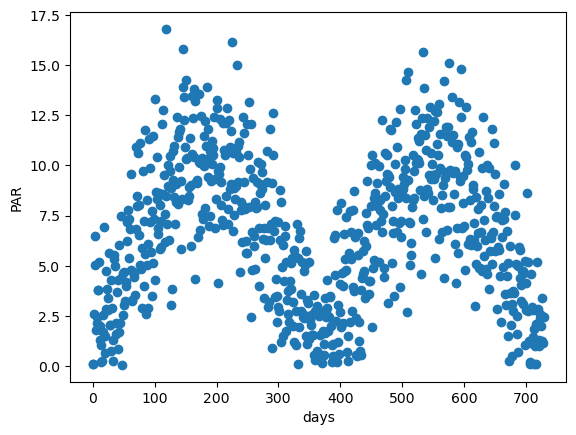

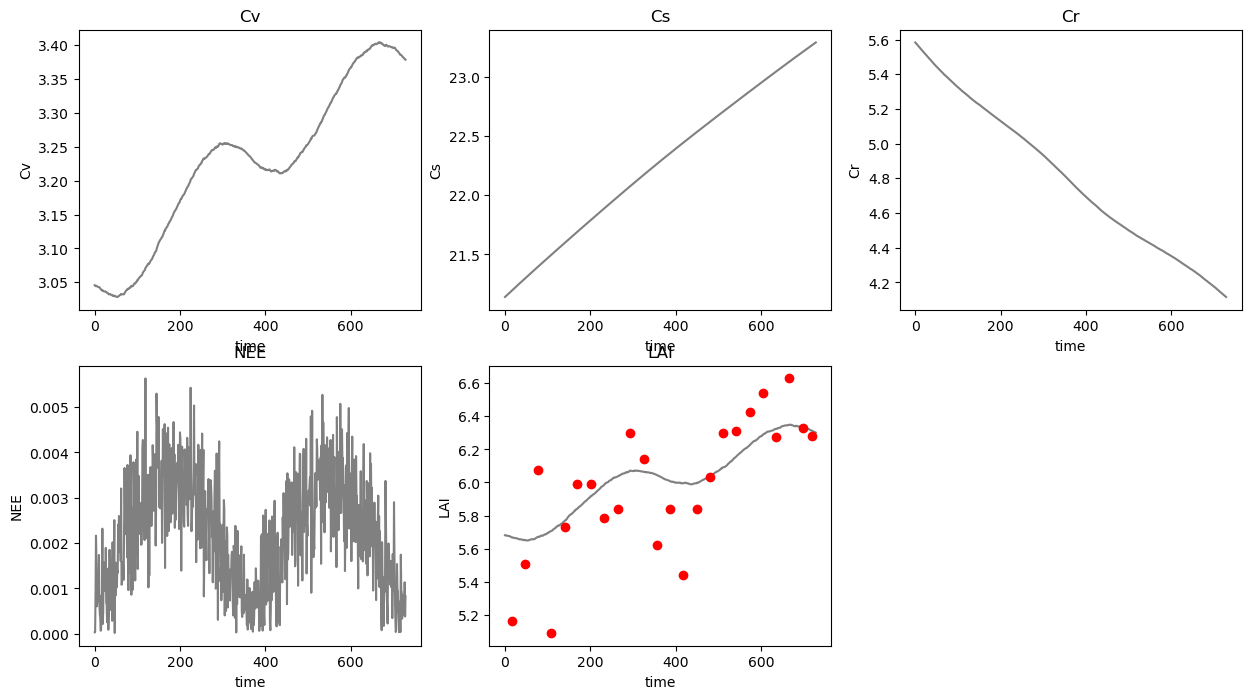

In [23]:
likelihood.plot_driver()
likelihood.plot_ground_truth()

In [26]:
likelihood.par_true

array([[7.92301322e-01, 1.86523322e+00, 6.84170991e-04, 5.04967614e-01,
        2.95868049e+03, 2.58846896e+04, 1.77011520e+03, 6.88359631e-01,
        3.04573410e+00, 2.11415896e+01, 5.58376223e+00]])

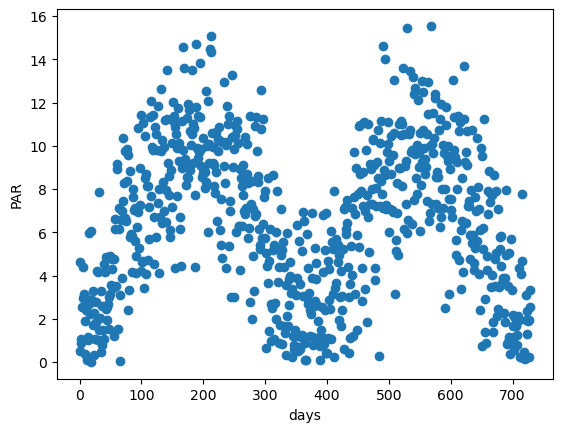

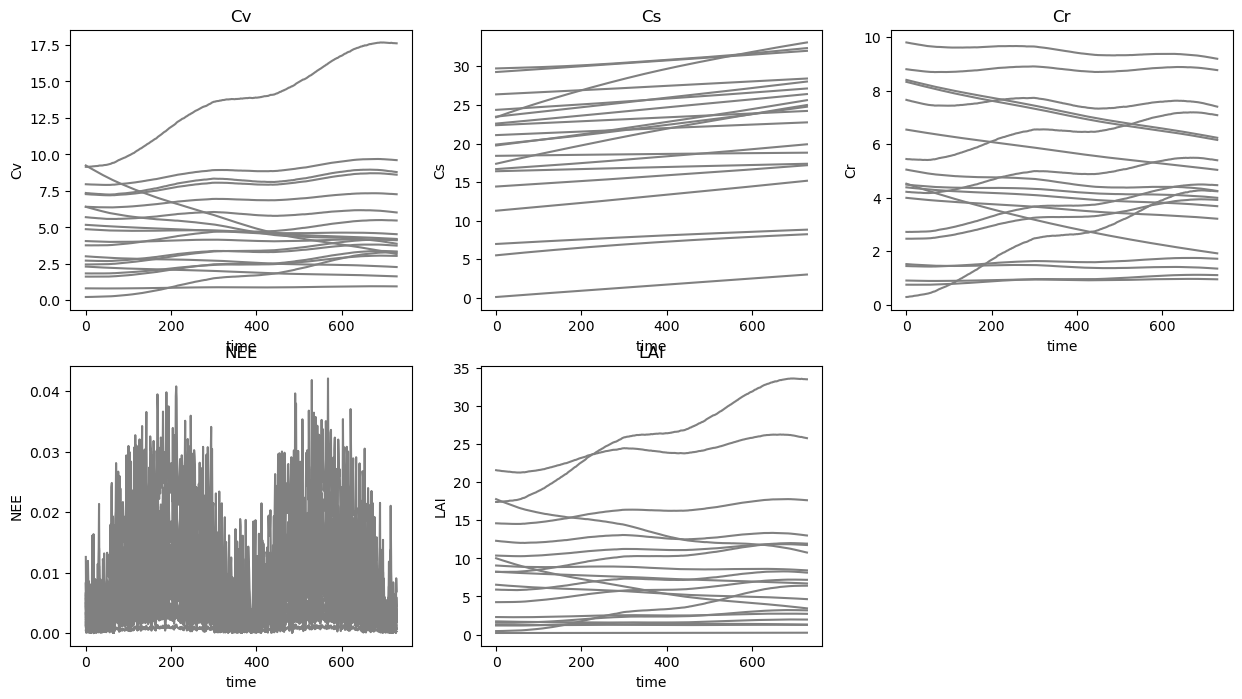

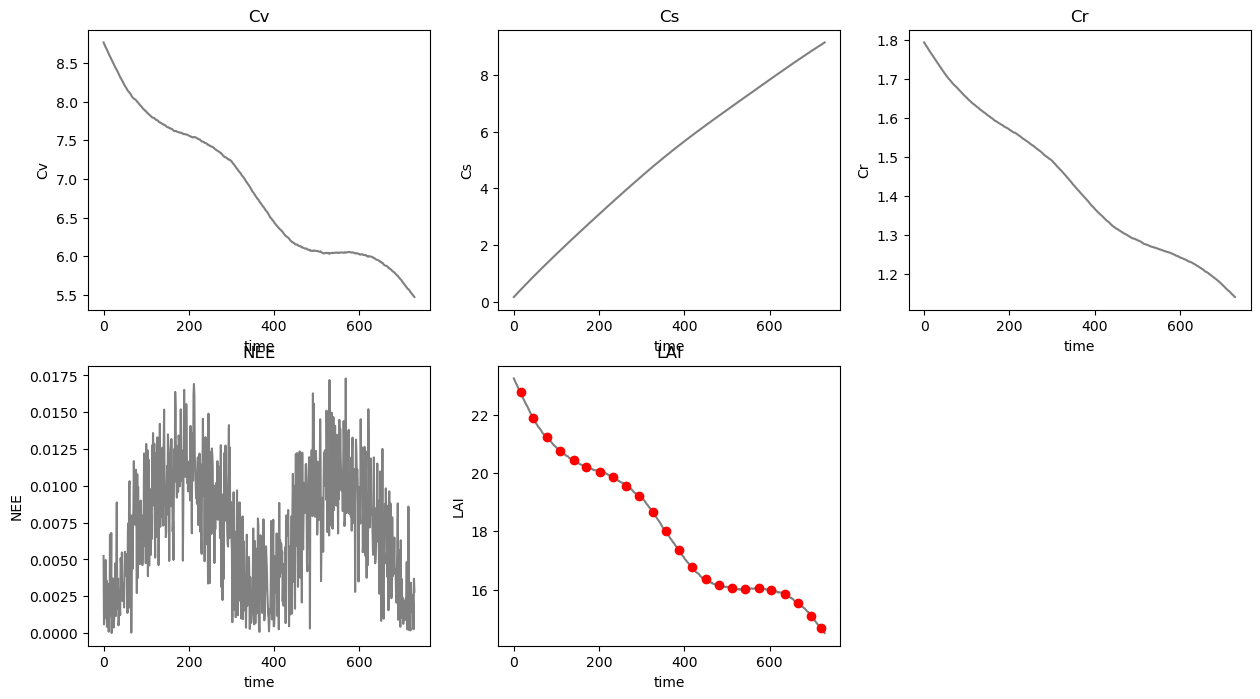

In [10]:
likelihood.plot_driver()
fig1 = likelihood.plot_vsem_outputs(prior.sample(20))
fig2 = likelihood.plot_vsem_outputs(prior.sample(), include_predicted_obs=True)

display(fig1)
display(fig2)

In [35]:
test = likelihood.par_to_obs_map(prior.sample(3))
test.shape

(3, 36)

In [ ]:

# par_names = ["KEXT", "Av"]
par_names = vsem.get_vsem_par_names()

forward_model = vsem.get_vsem_fwd_model(driver, par_names, simplify=False)

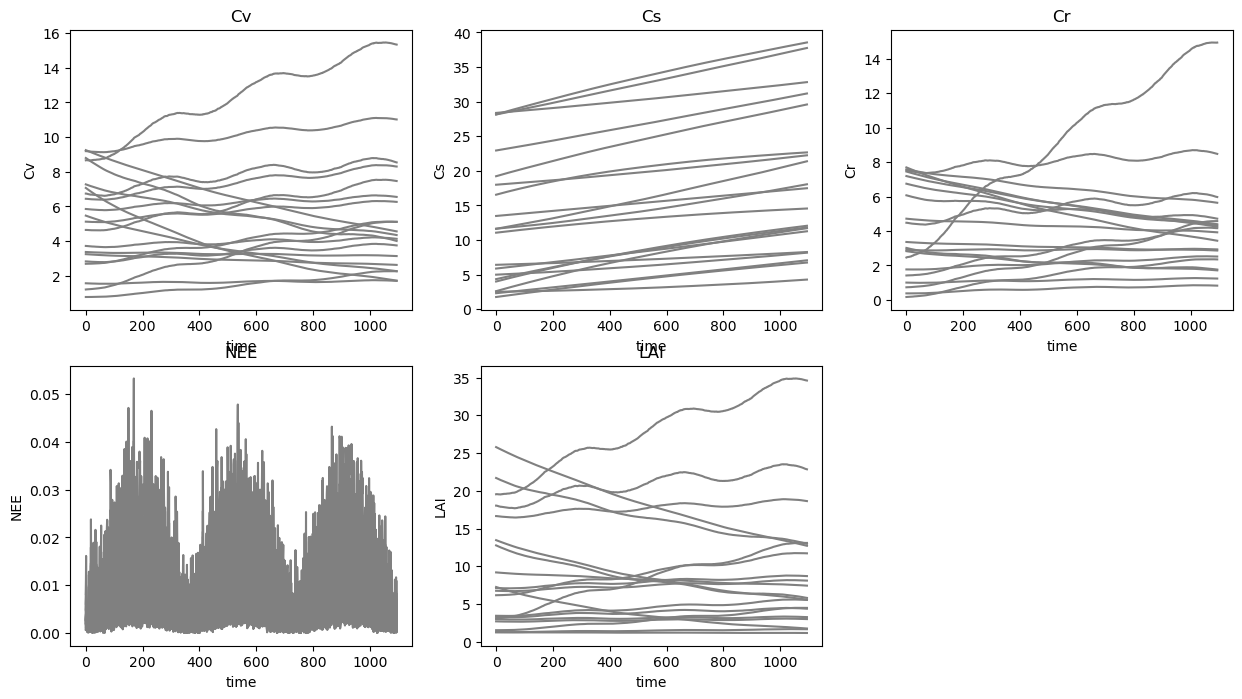

In [63]:
burn_in_start = 0
par = prior.sample(20)
# par_more_root = par.copy()
#par_more_root[0,:6] = par[0,:6] * 4
# par = np.vstack((par, par_more_root))


output = forward_model(par)
vsem_plot = vsem.plot_vsem_outputs(output[:,burn_in_start:,:], nrows=2)

display(vsem_plot)

In [ ]:
inv_prob = InvProb(rng, prior, likelihood)
samp, trace_plot = inv_prob.sample_posterior(n_samp=10000)

display(trace_plot)